<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_REINFORCE_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet box2d-py
import sys
import mxnet  
import gym
import numpy as np
import pandas as pd  
from mxnet import nd,autograd,init
from mxnet.gluon import nn,trainer
import matplotlib.pyplot as plt
from mxnet.gluon import Trainer

# Hyper Params

In [0]:
max_episodes = 1000
max_steps = 1000
log_interval = 10
solved_score = 5000
gamma = 0.99
lr = 0.001

# env

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(state_dim,action_dim)

4 2


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# PolicyNetwork and trainer

In [0]:
# define net
def build_policy(net,action_dim):
  with net.name_scope():
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(128,activation='relu'))
    net.add(nn.Dense(action_dim))
  return net
# create net
policy_net = build_policy(nn.HybridSequential(),action_dim)
policy_net.hybridize()
policy_net.initialize(init=init.Xavier())
trainer = Trainer(policy_net.collect_params(),'adam',{'learning_rate':lr})

# train loop

In [0]:
def train_loop(env,net,max_episodes=1000):
  
  # 紀錄每個episode的 Total_reward
  all_rewards = []
  
  # episode loop
  for episode in range(max_episodes):
    
    # start a new episode reset everything
    state = env.reset()
    log_probs = []
    rewards = []
    done = False
    
    # 對以下過程紀錄梯度
    with autograd.record():
      # Game loop
      while not done:
        
        # 與環境互動
        state = nd.array([state])
        probs = nd.softmax(policy_net(state))
        action,log_prob = nd.random.multinomial(probs,get_prob=True)
        state,reward,done,info = env.step(action.asnumpy()[0])
        
        # 紀錄互動數據
        log_probs.append(log_prob)
        rewards.append(reward)
      
      # 遊戲結束紀錄Total_reward
      all_rewards.append(np.sum(rewards))
      
      # 計算Gt
      R = 0
      for i in range(len(rewards)-1, -1, -1):
        R = rewards[i] + gamma * R
        rewards[i] = R
      
      # 規一化Gt
      rewards = np.array(rewards)
      rewards -= rewards.mean()
      rewards /= rewards.std()
      
      # 計算loss
      loss = []
      for log_prob,Gt in zip(log_probs,rewards):
        loss.append(-1*log_prob*Gt) #因為要最大化所以乘上-1
      
      # 反向傳播
      autograd.backward(loss)
    
    # net參數更新
    trainer.step(len(loss))
    
    # 固定步長打印當前遊戲資訊
    if episode % log_interval == 0:
      print(episode,all_rewards[-1])
  
  # 結束訓練畫出訓練曲線
  plt.plot(all_rewards)
  plt.plot(pd.Series(all_rewards).rolling(10).mean())
  plt.xlabel('Episode')
  plt.show()

0 10.0
10 13.0
20 20.0
30 39.0
40 14.0
50 65.0
60 18.0
70 34.0
80 42.0
90 47.0
100 118.0
110 91.0
120 51.0
130 77.0
140 189.0
150 311.0
160 212.0
170 238.0
180 254.0
190 125.0
200 278.0
210 87.0
220 460.0
230 500.0
240 500.0
250 500.0
260 500.0
270 500.0
280 295.0
290 361.0
300 305.0
310 343.0
320 274.0
330 143.0
340 302.0
350 500.0
360 500.0
370 500.0
380 435.0
390 175.0
400 500.0
410 500.0
420 472.0
430 500.0
440 345.0
450 500.0
460 500.0
470 418.0
480 500.0
490 500.0


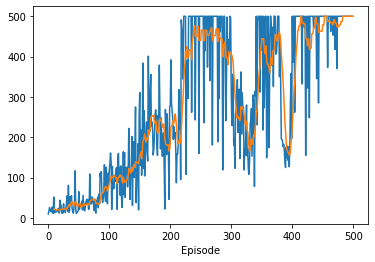

In [6]:
train_loop(env = env,
           net = policy_net,
           max_episodes = 500)

# model save and load

In [0]:
policy_net.export('{}_model'.format(env_name))
del policy_net

In [8]:
policy_net = nn.SymbolBlock.imports("{}_model-symbol.json".format(env_name), 
                                    ['data'], 
                                    "{}_model-0000.params".format(env_name))

/usr/local/lib/python3.6/dist-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


# test

In [10]:
env = gym.make('CartPole-v1')
for episode in range(10):
  state = env.reset()
  rewards = []
  done = False
  while not done:
    state = nd.array([state])
    probs = nd.softmax(policy_net(state))
    action = np.argmax(probs.asnumpy())
    state, reward, done, _ = env.step(action)
    rewards.append(reward)
  print(episode,np.sum(rewards))

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0 500.0
1 500.0
2 500.0
3 500.0
4 500.0
5 500.0
6 500.0
7 500.0
8 500.0
9 500.0
